In [1]:
%load_ext autoreload
%autoreload 2
#  base environment
from notebook_setup import *

import os
import dotenv
import numpy as np
import functools

# noise generation
from noise import pnoise2, pnoise3
from joblib import Parallel, delayed

# visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from tqdm import tqdm

# load environment variables
_ = dotenv.load_dotenv(override=True)


from data.synthetic import SpatioTemporalSlice, perlin_mask_sampler

# Irregular Simulations

Here we will introduce irregular datasets that are obtained from simulations. The running example here would be simulations that can be downloaded in `outputs/data/2D_NS_Re40.npy`. Run the following to load this simulation.


In [2]:
entire_dataset = np.load(os.path.join(os.getenv('DATA_DIR', './outputs/data'), '2D_NS_Re40.npy'))
initial_conditions = entire_dataset[:, 0, :, :]
simulations = entire_dataset[:, 1:, :, :]

Now let us visualize one of these simulations:


In [ ]:
SIMULATION_ID = 10

# Set up the figure and axis
fig, ax = plt.subplots()
img = ax.imshow(simulations[SIMULATION_ID, 0], cmap='viridis')  # Initial frame

# Function to update each frame
def update(frame):
    img.set_data(simulations[SIMULATION_ID, frame])  # Update image data
    ax.title.set_text(f'Time step: {frame}')  # Update title
    return [img]

# Create the animation
anim = FuncAnimation(fig, update, frames=simulations.shape[1], interval=100)

# Save the animation as a GIF using PillowWriter
anim.save(f'outputs/navier_stokes/simulation_{SIMULATION_ID}.gif', writer='pillow', fps=10)  # 10 frames per second

# Close the figure to avoid the extra plot
plt.close(fig)

# Display the animation
HTML(anim.to_jshtml())


## Make Irregular

Now to simulate the types of data that we might encounter in real world, we will make the data irregular by removing points spatiotemporal samples from the data.


### Perlin Noise Irregularity

Inspired by the way people generate random worlds, we use Perlin noise which is a class of gradient noises and allows for clustering of regions with high value and regions with low value.


In [4]:

scale = 10.0            # Controls the zoom level of the noise
octaves = 1             # Controls the level of detail (higher = more detail)
persistence = 0.5       # Amplitude scaling factor for each octave
lacunarity = 2.0        # Frequency scaling factor for each octave

simul, t, x, y = np.meshgrid(
    np.linspace(0, simulations.shape[0] / scale, simulations.shape[0]),
    np.linspace(0, simulations.shape[1] / scale, simulations.shape[1]),
    np.linspace(0, simulations.shape[2] / scale, simulations.shape[2]),
    np.linspace(0, simulations.shape[3] / scale, simulations.shape[3]),
    indexing='ij',
)

# Vectorize the noise function
noise_grid = np.vectorize(lambda s, t, x, y: pnoise3(y, x, t))(simul, t, x, y)

Now create a mask according to the sampled Perlin noise and a cutoff:


In [5]:
masking_cutoff = 0.4 # A number between 0 and 1 that determines the cutoff we use on the Perlin noise

perlin_mask = (noise_grid - noise_grid.min()) / (noise_grid.max() - noise_grid.min()) > masking_cutoff

Now we will visualize the masking corresponding to a simulation:


In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots()
img = ax.imshow(perlin_mask[SIMULATION_ID, 0], cmap='viridis')  # Initial frame
cbar = fig.colorbar(img, ax=ax)

# Function to update each frame
def update(frame):
    img.set_data(perlin_mask[SIMULATION_ID, frame])  # Update image data
    ax.title.set_text(f'Time step: {frame}')  # Update title
    return [img]

# Create the animation
anim = FuncAnimation(fig, update, frames=perlin_mask.shape[1], interval=100)

# Save the animation as a GIF using PillowWriter
anim.save(f'outputs/navier_stokes/perlin_mask_{SIMULATION_ID}.gif', writer='pillow', fps=10)  # 10 frames per second

# Close the figure to avoid the extra plot
plt.close(fig)

# Display the animation
HTML(anim.to_jshtml())


### Masking

After obtaining a random mask, we now make the original data irregular by omiting the masked samples. We first express everything in their coordinate representation:


In [ ]:

GRIDSIZE = 42
ANIMATION_LENGTH = simulations.shape[1]

# Create a tqdm progress bar for the animation frames
progress_bar = tqdm(total=ANIMATION_LENGTH, desc="Animating", leave=True)

# Set up the figure and axis
fig, ax = plt.subplots()
x_coor, y_coor = np.where(perlin_mask[SIMULATION_ID, 0] == 1)
hb = ax.hexbin(x=x_coor, y=y_coor, C=simulations[SIMULATION_ID, 0][x_coor, y_coor], gridsize=GRIDSIZE, cmap='coolwarm')

# Function to update each frame
def update(frame):
    global hb
    # Remove the previous hexbin collection
    for coll in ax.collections:
        coll.remove()
    x_coor, y_coor = np.where(perlin_mask[SIMULATION_ID, frame] == 1)
    hb = ax.hexbin(x=x_coor, y=y_coor, C=simulations[SIMULATION_ID, frame][x_coor, y_coor], gridsize=GRIDSIZE, cmap='coolwarm')  # Redraw hexbin plot
    ax.title.set_text(f'Time step: {frame}')  # Update title
    # Update the progress bar
    progress_bar.update(1)
    return [hb]

# Create the animation
anim = FuncAnimation(fig, update, frames=ANIMATION_LENGTH, interval=100)

# Save the animation as a GIF using PillowWriter
anim.save(f'outputs/navier_stokes/simulation_masked_{SIMULATION_ID}.gif', writer='pillow', fps=10)  # 10 frames per second

# Close the figure to avoid the extra plot
plt.close(fig)

# Display the animation
HTML(anim.to_jshtml())


## Regional Simulated Datasets

Now we move on to creating regional datasets out of our simulation and masking. This is aimed to mimic the real-world climate data that we encounter. To do so, we will use the regional dataset class which basically samples a random simulation, takes a 3D grid out of that simulation, adds some sort of masking (for example, with Perlin noise), and then returns the simulated datasets.

You may run the following code to visualize a set of these simulations. The following will first instantiate a regional dataset:


In [8]:
dset = SpatioTemporalSlice(
    entire_simulation=simulations,
    spatial_window=(32, 32),
    temporal_window=16,
    mask_sampler=functools.partial(perlin_mask_sampler, cutoff=0.0),
    total_count=16,
)

Animating: 1002it [01:00, 37.84it/s]

The following code will visualize the first 9 elements of the regional dataset that are visualized in 9 different subplots. Each subplot is a scatterplot of the irregular simulation:


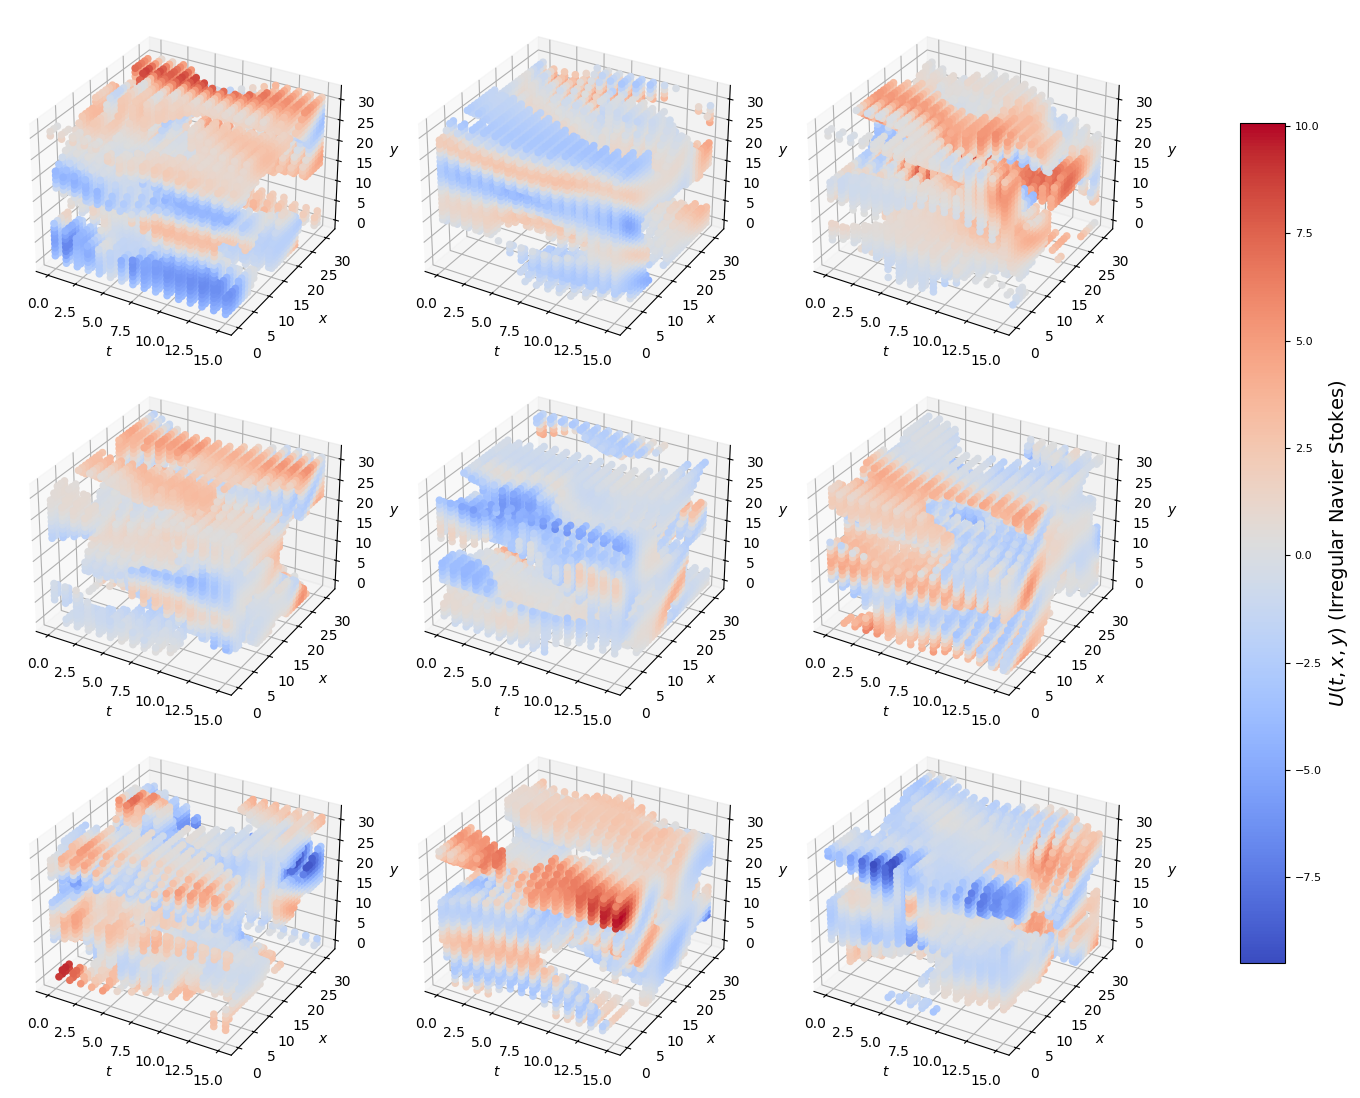

In [11]:
# Create a figure and set of subplots (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(15, 12), subplot_kw={'projection': '3d'})

# Define the normalization for the colorbar
vmin = np.min([dset[i * 3 + j][1].min() for i in range(3) for j in range(3)])  # Minimum value across all intensities
vmax = np.max([dset[i * 3 + j][1].max() for i in range(3) for j in range(3)])  # Maximum value across all intensities
norm = Normalize(vmin=vmin, vmax=vmax)

# Iterate over each subplot and generate the scatter plot
for i in range(3):
    for j in range(3):
        coords, intensity = dset[i * 3 + j]
        t, x, y = coords
        ax = axes[i, j]
        sc = ax.scatter(t, x, y, c=intensity, cmap='coolwarm', alpha=1.0, norm=norm)
        # Set labels for the axes
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$y$')

# Add a global colorbar
# Adjust layout to leave margin for colorbar and general spacing
fig.subplots_adjust(left=0.05, right=0.8, top=0.95, bottom=0.05, wspace=0.12, hspace=0.0)
sm = ScalarMappable(cmap='coolwarm', norm=norm)  # Create ScalarMappable to link colormap with data normalization
sm.set_array([])  # Dummy array for ScalarMappable; needed to generate the colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # [left, bottom, width, height] for the colorbar
cbar = fig.colorbar(sm, ax=axes[:, -1], fraction=0.1, pad=0.1, cax=cbar_ax)  # Add colorbar to the rightmost column
cbar.set_label('$U(t, x, y)$ (Irregular Navier Stokes)', fontsize=14)  # Set the label for the colorbar
# set the fontsize for the ticks of the colorbar larger

# make the ticks smaller
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.get_offset_text().set(size=8)

# Show the entire figure
plt.show()


In [12]:
batch_size, dim, K = 10, 3, 1000
import torch
# Assuming x is your input tensor of shape (batch_size, dim, K)
x = torch.randn(batch_size, dim, K)

# Permute to (batch_size, K, dim)
x_permuted = x.permute(0, 2, 1)  # Now shape is (batch_size, K, dim)

# Compute pairwise distances using torch.cdist
# This will return a tensor of shape (batch_size, K, K)
distance_matrix = torch.cdist(x_permuted, x_permuted, p=2)
C = distance_matrix + 10000 * torch.eye(K).repeat(batch_size, 1, 1)
print(C.shape)
L = torch.linalg.cholesky(C)
print(L.shape)

torch.Size([10, 1000, 1000])
torch.Size([10, 1000, 1000])
